In [1]:
import numpy as np
import disc2radmc 
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import json
from scipy import interpolate

%matplotlib inline

In [2]:
## Here you define the surface density distribution as a function of r and phi (azimuthal angle).
## It doesn't need to be normalized as the code will scale it to match the total dust mass specified.

def Sigma_dust(r, phi,  Ms, rcs, sigrs):
    ## Multiple radial Gaussians with masses Ms, central radii rcs, and standard deviations sigrs
    
    Ncomponents=len(Ms)
    S=np.zeros_like(r)
    for i in range(Ncomponents):
        S+=Ms[i]*np.exp( -0.5 * ((r-rcs[i])/sigrs[i])**2.)/(sigrs[i]*rcs[i]) # normalized so the relative mass of each ring is right
    return S

(1e-10, 1.049999999999999)

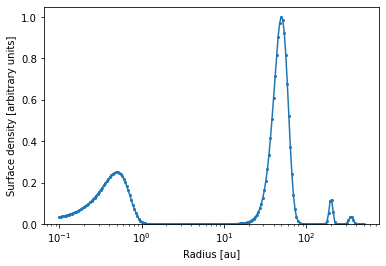

In [3]:
##############################
###### MODEL PARAMETERS ######
##############################

## STAR (set to match HD141569)
dpc=111.6  # [pc] distance to source 
target='HD141569'# name
Rstar=1.8 # [Solar radii]
Tstar=8500 # [K] If this is negative, the code will consider the star as a blackbody. 
g=4.0
# For a realistic stellar model, you can download bt-settl models 
# from http://svo2.cab.inta-csic.es/theory/newov2/index.php and indicate their directory below
dir_stellar_templates='/Users/Sebamarino/Astronomy/Stellar_templates/BT-Settl/bt-settl/'
# The code will then search for files named as 
# dir_stellar_templates+'lte%03i-%1.1f-0.0a+0.0.BT-NextGen.7.dat.txt'%(Tstar//100,g) if Tstar>=2600
# dir_stellar_templates+'lte%03i-%1.1f-0.0.BT-Settl.7.dat.txt'%(T//100,g)            else
# and interpolate models with neighbouring temperatures if necessary

## DUST parameters
Mdusts=[5.0e-5, 1.0, 0.5, 0.5] # [Mearth] mass of each ring component
rcs=[0.5, 50., 200., 350.]     # [au] center of each Gaussian ring
sigrs=[0.2, 10., 10., 20.]     # [au] standard deviation of each ring
h=0.05                         # vertical aspect ratio =H/r, where H is the vertical standard deviation. This is a constant, but other parametrizations are possible. 
par_sigma=(Mdusts, rcs, sigrs) # list containing the parameters that define the dust surface density. They must be in the same order as in the definition of Sigma_dust

# total dust mass
Mdust=np.sum(Mdusts)

# grain size distribution parameters
amin=10.0      # [micron]  minimum grain size (1 by default)
amax=1.0e4     # [micron]  maximum grain size (1e4 by default)
N_species=3    #  (1 by default) Number of dust size bins to use for the radiative transfer calculations. 
slope = -3.5   #  (-3.5 by default) Slope of the size distribution. This is used for computing opacities and for the mass distribution of each size bin

## MODEL SPATIAL GRID
rmin=0.1 # [au] make sure it is small enough to sample the surface density
rmax=500.# [au] make sure it is large enough to sample the surface density
Nr=200    # number of radial cells (linearly or logspaced)
Nphi=100  # number of azimuthal cells
Nth=1     # number of polar angle cells (for only one emisphere)
thmax=np.arctan(h)*1 # maximum polar angle to sample as measured from the midplane.
axisym=False # Consider the disc to be axisymmetric to speed up calculations? it can overwrite Nphi if True and set it to 1
mirror=False  # Mirror the upper half to speed up calculations. This is incompatible with anisotropic scattering.
logr=True # Sample r logarithmically or linearly

# WAVELENGTH GRID (grid to sample the stellar flux in temperature calculations, see radmc3d manual)
lammin=0.09  # [mu]  minimum wavelength to consider in our model (important for temperature calculation)
lammax=1.0e5 # [mu] minimum wavelength to consider in our model (important for temperature calculation)
Nlam=150     # number of cells logarithmically spaced to sample the wavelength range.

# IMAGE PARAMETERS
Npix=400  # number of pixels
dpix=0.027491 # pixel size in arcsec
PA=-8.0   # position angle
inc=-55.0  # inclination (sign matters to define near or far side)

wavelength=[10.575, 11.3, 15.50] # [um] image wavelength. It can be a float or an array of wavelengths
scattering_mode=2 # scattering mode (0=no scattering, 1=isotropic, 2=anisotropic using H&G function)

### plot surface density profile to check it makes sense
rs=np.logspace(np.log10(rmin), np.log10(rmax), Nr)
S=Sigma_dust(rs, 0., *par_sigma)
plt.plot(rs,S/np.max(S), ls='-', marker='o', ms=2)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Radius [au]')
plt.ylabel('Surface density [arbitrary units]')
plt.ylim(1.0e-10,)

In [4]:
### PHYSICAL GRID (this only needs to be run once at the beginning to define the model)
gridmodel=disc2radmc.physical_grid(rmin=rmin, rmax=rmax, Nr=Nr, Nphi=Nphi, Nth=Nth, thmax=thmax, mirror=mirror, logr=logr, axisym=axisym)
gridmodel.save()

### WAVELENGTH GRID (this only needs to be run once at the beginning)
lammodel=disc2radmc.wavelength_grid(lammin=lammin, lammax=lammax, Nlam=Nlam)
lammodel.save()

### STAR (this only needs to be run once if you don't have the stars.inp file)
# starmodel=disc2radmc.star(lammodel,
#                           Tstar=Tstar,
#                           Rstar=Rstar,
#                           g=g,
#                           dir_stellar_templates=dir_stellar_templates # necessary line if Tstar>0
#                         )
# starmodel.save()

In [7]:
### DUST SIZE DISTRIBUTION AND OPACITY (this only needs to be run once at the beginning)
# path to optical constants that can be found at
# https://github.com/SebaMarino/disc2radmc/tree/main/opacities/dust_optical_constants
path_opct='/Users/Sebamarino/Astronomy/Codes/disc2radmc/opacities/dust_optical_constants/' 
lnk_files=[path_opct+'astrosilicate_ext.lnk',
           path_opct+'ac_opct.lnk',
           path_opct+'ice_opct.lnk']
densities=[4., 3., 1.] # densities in g/cm3
mass_weights=[1.0, 0., 0.] # mixing ratios by mass
dust=disc2radmc.dust(lammodel,
                     Mdust=Mdust,
                    lnk_file=lnk_files,
                    densities=densities,
                    N_species=N_species,
                    slope=slope,
                    N_per_bin=100, # number of species per size bin to have a good representation 
                    mass_weights=mass_weights,
                    tag='mix', # name to give to this new mixed species
                    compute_opct=False) # only set to true if you are changing the dust composition

# Compute dust opaicties with Mie theory only if you have changed the size distribution parameters or optical constants.
# It requires having the file makeopac in the same working directory. 
# makeopac can be found and compiled from files at https://github.com/SebaMarino/disc2radmc/tree/main/opacities/Mie
# dust.compute_opacities()


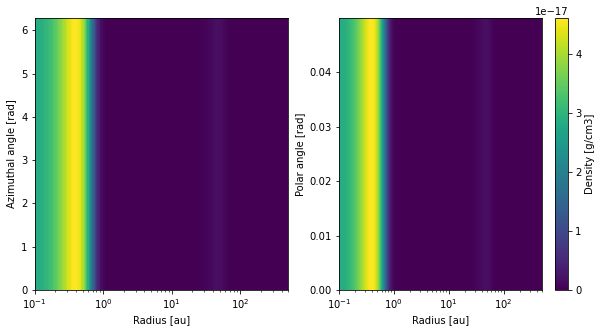

In [12]:
### DUST DENSITY DISTRIBUTION (this needs to be every time the spatial distribution or total masses are changed)
dust.dust_densities(grid=gridmodel,function_sigma=Sigma_dust, par_sigma=par_sigma, h=h)
dust.write_density()

# check density (northern emisphere)
Density=np.loadtxt('./dust_density.inp', max_rows=gridmodel.Nr*gridmodel.Nphi*gridmodel.Nth, dtype=float, skiprows=3).reshape( (gridmodel.Nphi, gridmodel.Nth, gridmodel.Nr))

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

pc1=ax1.pcolormesh(gridmodel.redge, gridmodel.phiedge, Density[:,gridmodel.Nth-1,:])
pc2=ax2.pcolormesh(gridmodel.redge, gridmodel.thedge[::-1], Density[0,:gridmodel.Nth,:])

ax1.set_xlabel('Radius [au]')
ax2.set_xlabel('Radius [au]')

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylabel(r'Azimuthal angle [rad]')
ax2.set_ylabel(r'Polar angle [rad]')

fig.colorbar(pc1, ax=ax2,label='Density [g/cm3]')


In [13]:
## SET SOME BASIC PARAMETERS TO TELL RADMC3D HOW MANY PHOTONS AND WHAT KIND OF SCATTERING WE WANT TO CONSIDER (only necessary to run the first time)
sim=disc2radmc.simulation(nphot=10000000, # number of photon packages for thermal monte carlo
                        nphot_scat=1000000, # number of photon packages for image
                        nphot_spec=10000,   # number of photon packages for spectrum
                        scattering_mode=scattering_mode, 
                        modified_random_walk=0, # for very optically thick medium, this is a useful approximation
                        istar_sphere=0, # consider the star a sphere or a point.
                        setthreads=4,
                        verbose=True, 
                            )
### RUN MCTHERM to compute temperature (only necessary to run once, or every time the grid has changed or if the dust mass is high enough to affect the temperature field, i.e. optically thick)
sim.mctherm()

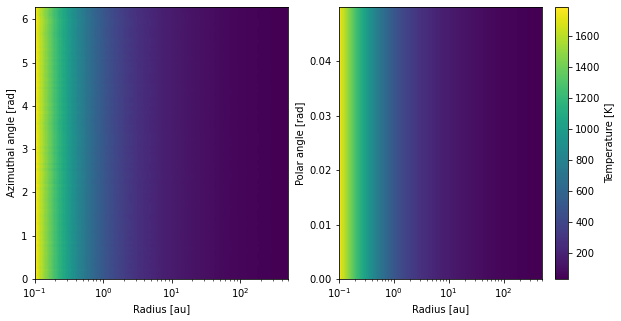

In [14]:
# check temperature (northern emisphere)
Ts=np.fromfile('./dust_temperature.bdat', count=gridmodel.Nr*gridmodel.Nphi*gridmodel.Nth+4, dtype=float )[4:].reshape( (gridmodel.Nphi, gridmodel.Nth, gridmodel.Nr))

fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

pc1=ax1.pcolormesh(gridmodel.redge, gridmodel.phiedge, Ts[:,gridmodel.Nth-1,:])
pc2=ax2.pcolormesh(gridmodel.redge, gridmodel.thedge[::-1], Ts[0,:gridmodel.Nth,:])

ax1.set_xlabel('Radius [au]')
ax2.set_xlabel('Radius [au]')

ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_ylabel(r'Azimuthal angle [rad]')
ax2.set_ylabel(r'Polar angle [rad]')

fig.colorbar(pc1, ax=ax2,label='Temperature [K]')

In [15]:
### make sed
wavelengths=np.logspace(0.,3.5, 100)  # um
sed=sim.simsed(wavelengths=wavelengths, dpc=dpc, inc=inc)

### load photometry collected by Grant

data = json.load(open('phoenix_m+modbb_disk_r+modbb_disk_r_.json','r'))
### photometry
wav_p=data['phot_wavelength'][0]
fnu_p=data['phot_fnujy'][0]
fnu_pe=data['phot_e_fnujy'][0]


ignore_p=data['phot_ignore'][0]
upper_lim=data['phot_upperlim'][0]

star=data['star_spec']

for i in range(len(ignore_p)):
    if wav_p[i]<2.0 and fnu_p[i]<2.0:
        ignore_p[i]=True

(0.0001, 10.0)

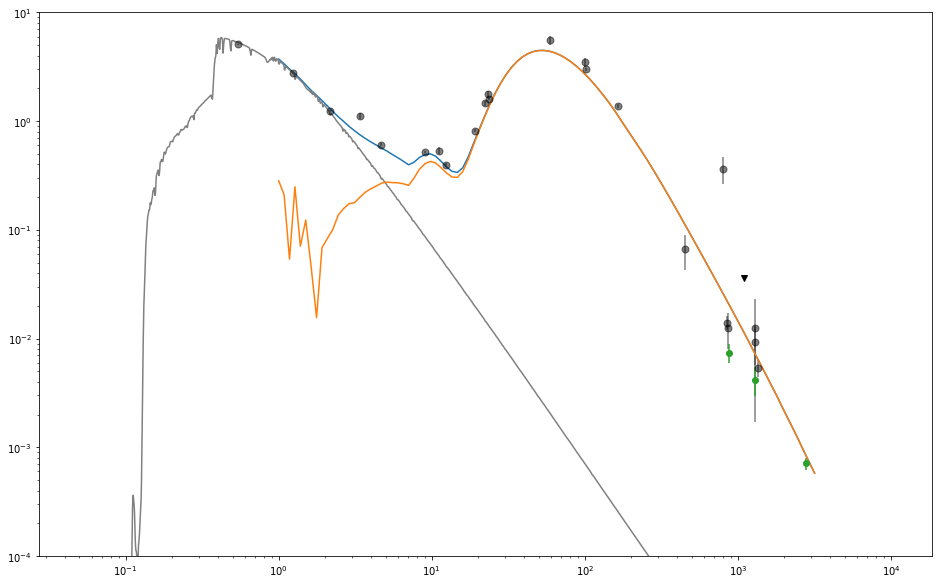

In [16]:
## plot sed

fstar=interpolate.interp1d(star['wavelength'], star['fnujy'])

plt.figure(figsize=(16,10))

plt.plot(sed[:,0], sed[:,1])
plt.plot(star['wavelength'], star['fnujy'], color='grey')
plt.plot(sed[:,0], sed[:,1]-fstar(sed[:,0]))

plt.xscale('log')
plt.yscale('log')
plt.ylim(1.0e-6, 10.0)

for i in range(len(wav_p)):
    if upper_lim[i] and ignore_p[i]==False:
        plt.plot(wav_p[i],fnu_p[i], "v", color='black')
    elif ignore_p[i]==False:
        plt.errorbar(wav_p[i],fnu_p[i], yerr=fnu_pe[i], fmt='o', color='black', ms=7.0, alpha=0.5)

## Di Folco+2020
plt.errorbar([870., 1300., 2800.], np.array([7.42, 4.2, 0.71])*1.0e-3, yerr=np.array([1.42, 1.24, 0.09])*1.0e-3, fmt='o')
        
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.0e-4, 1.0e1)


In [17]:
%%time
### MAKE IMAGE
sim.simimage(dpc=dpc, 
             imagename='MIRI_FQPM', 
             wavelength=wavelength,
             Npix=Npix,
             dpix=dpix,
             inc=inc,
             PA=PA,
             tag=target)

image size = 1.2e+03 au
radmc3d image incl -55.00000  phi  0.00000 posang -98.00000  npix 400  loadlambda sizeau 1227.19824  secondorder
CPU times: user 266 ms, sys: 19.1 ms, total: 285 ms
Wall time: 5.63 s


Total flux [mJy] =  [477.24875 436.7356  351.98734]


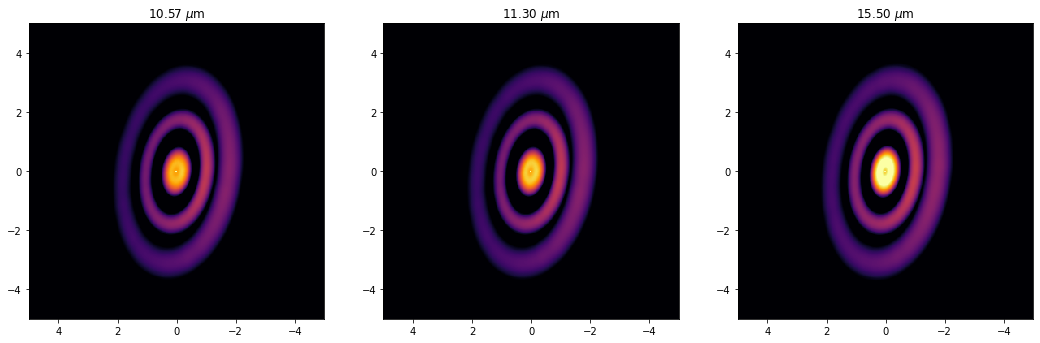

In [18]:
######################
### PLOT IMAGE #######
######################
## import image or image cube
fit1=pyfits.open('./images/image_MIRI_FQPM_'+target+'.fits')
image=fit1[0].data[0,:,:,:]

## calculate pixel edges positions
pixel_size=fit1[0].header['CDELT2']*3600.0 # arcsec
Np=np.shape(image)[-1]
xs=np.zeros(Np+1)
ys=np.zeros(Np+1)
for i in range(Np+1):
    xs[i]=-(i-Np/2.0)*pixel_size
    ys[i]=(i-Np/2.0)*pixel_size

print('Total flux [mJy] = ',(image.sum(axis=(1,2))*1.0e3))
fig=plt.figure(figsize=(18,6))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)


pc1=ax1.pcolormesh(xs, ys, np.log10(image[0,:,:]/np.max(image[0,:,:])+1.0e-30), cmap='inferno', vmin=-10, vmax=-3)
pc2=ax2.pcolormesh(xs, ys, np.log10(image[1,:,:]/np.max(image[1,:,:])+1.0e-30), cmap='inferno', vmin=-10, vmax=-3)
pc3=ax3.pcolormesh(xs, ys, np.log10(image[2,:,:]/np.max(image[2,:,:])+1.0e-30), cmap='inferno', vmin=-10, vmax=-3)

# fig.colorbar(pc3, ax=ax0, orientation='horizontal')
# ax1.pcolormesh(xs, ys, (image/np.max(image))), vmax=-2)

axs=[ax1, ax2, ax3]
for i, axi in enumerate(axs):
    axi.set_title(r'%1.2f $\mu$m'%wavelength[i])
    axi.set_xlim(5.0, -5.)
    axi.set_ylim(-5.0, 5.)
    axi.set_aspect('equal')